In [1]:
import pickle
from scipy.stats import pearsonr, spearmanr
import pandas as pd
import numpy as np
import math
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(font_scale=1.6)
from matplotlib.colors import LogNorm

fpath = "/Users/ys8mz/Box Sync/Predictive Models of College Completion (VCCS)/intermediate_files"
output_fpath = "/Users/ys8mz/Box Sync/Predictive Models of College Completion (VCCS)/evaluation_results/truncated_predictors/cleaned_results"

In [1]:
pred_dict = {}
for m in ['lr','ols','rf','xgb', 'rnn', 'cox']:
    if m == 'coxph':
        pred_dict[m + "ph"] = list(pickle.load(open(fpath + "/y_test_pred_{}.p".format(m), 'rb')))
        
m_dict = {'lr': 'Logit', 'ols': 'OLS',
          'rf': 'RF', 'xgb': 'XGBoost',
          'rnn': 'RNN', 'coxph': 'CoxPH'}
m_list = ['ols','lr','coxph','rf','xgb','rnn']

#### (1) Binary_Accuracy (Use for section IV of the paper)

In [38]:
thresholds_dict = {}
thresholds_dict['coxph'] = 0.36722685193132715
thresholds_dict['rnn'] = 0.3519462
thresholds_dict['ols'] = 0.46918787407941415
thresholds_dict['lr'] = 0.43344163040148626
thresholds_dict['rf'] = 0.3861673467925198
thresholds_dict['xgb'] = 0.38526425

In [43]:
pred_bin = {}
for m,l in pred_dict.items():
    pred_bin[m] = np.where(np.array(pred_dict[m]) > thresholds_dict[m], 1, 0)[:-1]
    
data = pd.read_stata(fpath + "/full_data_truncated.dta")
y_real = np.array(data[data.valid==1].loc[:,'grad_6years'])

for m,l in pred_bin.items():
    print(m, sum(l == y_real), sum(l == y_real) - sum(pred_bin['ols'] == y_real))

xgb 27800 681
rnn 27406 287
rf 27034 -85
lr 27242 123
coxph 27035 -84
ols 27119 0


#### (2) Correlation in binary outcome -- used for generating Figure 4 of the paper

In [7]:
data = pd.read_stata(fpath + "/full_data_truncated.dta")
y_real = data[data.valid==1].loc[:,['vccsid','grad_6years']]

In [9]:
pred_bin = {}
for m in m_list:
    pred_bin[m] = np.where(pred_dict[m] > thresholds_dict[m], 1, 0)

In [10]:
common = np.zeros((6,6))
for i in range(6):
    for j in range(6):
        if i > j:
            common[i,j] = round(sum(pred_bin[m_list[i]] == pred_bin[m_list[j]])/len(pred_bin[m_list[i]]),4)
common_df = pd.DataFrame(common, columns=['OLS', 'Logit', 'CoxPH', 'RF', 'XGBoost', 'RNN'])
common_df.index = ['OLS', 'Logit', 'CoxPH', 'RF', 'XGBoost', 'RNN']

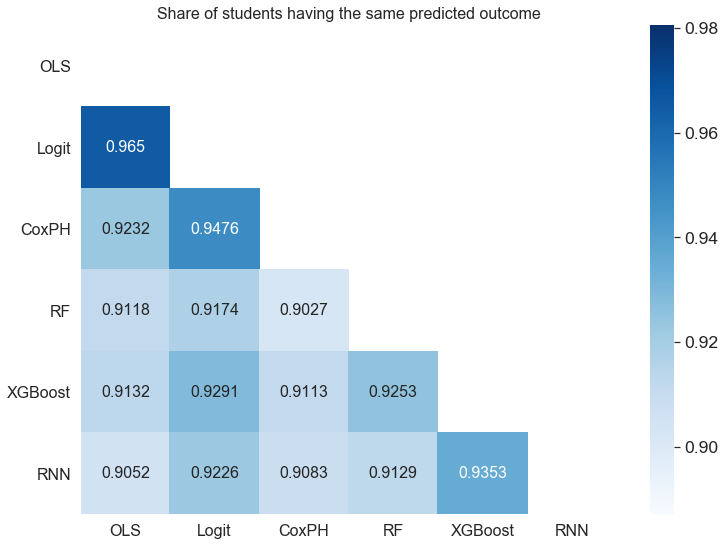

In [11]:
for i in range(6):
    for j in range(6):
        if j >= i:
            common_df.iloc[i,j] = np.nan
vmin = np.nanmin(common_df.iloc[:,:].get_values())
vmax = np.nanmax(common_df.iloc[:,:].get_values())
l = vmax - vmin
mask = np.zeros_like(common_df)
mask[np.triu_indices_from(mask)] = True
plt.figure(figsize=(12,9))
g = sns.heatmap(common_df, mask=mask, annot=True, cmap='Blues',fmt='.4g',
                vmin=max(0,vmin-0.25*l),vmax=min(1,vmax+0.25*l),
                annot_kws={"size": 16})
g.set_yticklabels(g.get_yticklabels(), rotation = 0, fontsize=16)
g.set_xticklabels(g.get_xticklabels(), fontsize=16)
g.set_facecolor("white")
plt.title("Share of students having the same predicted outcome", fontsize=16)
plt.savefig(output_fpath + "/pred_score_comparison/share_of_same_predicted_outcome.png", bbox_inches="tight")
plt.show()